## Прогнозирование цен на бриллианты

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedShuffleSplit 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import category_encoders as ce

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.linear_model import  Lars, OrthogonalMatchingPursuit, SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error

In [4]:
#pip install category_encoders

In [5]:
path_train = 'diamonds_train.csv' # содержит только имя файла, без имен папок !!!

In [6]:
df = pd.read_csv(path_train)
df.head()

,size,color,clarity,cut,symmetry,polish,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,0.50,K,SI2,Excellent,Excellent,Excellent,61.4,55.0,5.10,5.12,3.14,990
1,0.50,E,VVS2,Excellent,Excellent,Very Good,61.9,60.0,5.06,5.09,3.14,3384
2,0.35,G,VS2,Excellent,Excellent,Excellent,63.0,55.0,4.47,4.51,2.83,1154
3,0.30,E,SI2,Excellent,Excellent,Excellent,63.2,57.0,4.24,4.27,2.69,886
4,0.30,F,VS2,Very Good,Very Good,Excellent,63.4,61.0,4.24,4.26,2.69,864


In [7]:
df[['cut', 'total_sales_price']].groupby('cut').mean()

,total_sales_price
cut,
Excellent,2785.474744
Very Good,2636.531273


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67598 entries, 0 to 67597
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   size               67598 non-null  float64
 1   color              67598 non-null  object 
 2   clarity            67598 non-null  object 
 3   cut                67598 non-null  object 
 4   symmetry           67598 non-null  object 
 5   polish             67598 non-null  object 
 6   depth_percent      67598 non-null  float64
 7   table_percent      67598 non-null  float64
 8   meas_length        67598 non-null  float64
 9   meas_width         67598 non-null  float64
 10  meas_depth         67598 non-null  float64
 11  total_sales_price  67598 non-null  int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 6.2+ MB


In [9]:
df.describe()

,size,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
count,67598.000000,67598.000000,67598.000000,67598.000000,67598.000000,67598.000000,67598.000000
mean,0.504181,62.106799,57.793840,4.911646,4.943448,3.060767,2755.178393
std,0.306526,1.309775,1.853719,0.869997,0.875224,0.545834,3341.411466
min,0.150000,55.000000,0.000000,2.270000,3.420000,0.000000,242.000000
25%,0.300000,61.400000,56.000000,4.290000,4.310000,2.680000,898.000000
50%,0.400000,62.300000,58.000000,4.600000,4.640000,2.880000,1236.000000
75%,0.570000,62.800000,59.000000,5.290000,5.330000,3.290000,3208.000000
max,2.000000,66.500000,67.000000,8.180000,8.230000,6.860000,19996.000000


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
categorical_features = ['cut', 'color', 'symmetry', 'polish']
clarity_feature = ['clarity']
numerical_features = ['size', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth']

In [12]:
y = np.array(df.total_sales_price)
X = df.drop(columns=['total_sales_price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

Создадим трансформер и попробуем применить модель ближайших соседей

In [13]:
numerical = Pipeline(
    steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)),
    ('scaler', MinMaxScaler())]
)

clarity_map = [{
    'col':'clarity',
    'mapping':{'FL':10, 'IF':9, 'VVS1':8, 'VVS2':7, 'VS1':6, 'VS2':5, 
               'SI1':4, 'SI2':3, 'I1':2, 'I2':1, 'I3':0}
    }]

clarity_transformer = Pipeline(
    steps=[
    ('missing_num', SimpleImputer(strategy = 'most_frequent')),
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])    
    
data_transformer = ColumnTransformer([
        ("numerical", numerical, numerical_features),
        # убрать быстую разряженную и затем добавить тип pandas
        ("cat", OneHotEncoder(sparse_output=False).set_output(transform="pandas"), categorical_features),
        ("ordinal_map", clarity_transformer, ['clarity'])
        ]).set_output(transform='pandas')

# Создание конвейера препроцессора, который сначала преобразует данные.
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', KNeighborsRegressor())])


In [14]:
data_transformer.fit_transform(df)

,numerical__size,numerical__depth_percent,numerical__table_percent,numerical__meas_length,numerical__meas_width,numerical__meas_depth,cat__cut_Excellent,cat__cut_Very Good,cat__color_D,cat__color_E,...,cat__color_I,cat__color_J,cat__color_K,cat__color_L,cat__color_M,cat__symmetry_Excellent,cat__symmetry_Very Good,cat__polish_Excellent,cat__polish_Very Good,ordinal_map__clarity
0,0.189189,0.556522,0.808521,0.478849,0.353430,0.386139,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.333333
1,0.189189,0.600000,0.888304,0.472081,0.347193,0.386139,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.777778
2,0.108108,0.695652,0.808521,0.372250,0.226611,0.334983,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.555556
3,0.081081,0.713043,0.840434,0.333333,0.176715,0.311881,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.333333
4,0.081081,0.730435,0.904260,0.333333,0.174636,0.311881,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67593,0.081081,0.817391,0.808521,0.324873,0.164241,0.315182,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.333333
67594,0.243243,0.643478,0.872347,0.529611,0.415800,0.425743,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.555556
67595,0.113514,0.634783,0.808521,0.385787,0.243243,0.338284,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.777778
67596,0.140541,0.669565,0.840434,0.417936,0.282744,0.359736,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.444444


In [14]:
# Определим параметры для перебора по решетке
p = np.arange(1,3)
n_neighbors = np.arange(1,10)
scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler() ]

# Подбор параметров для модели
param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'knn': [KNeighborsRegressor()],
         'knn__n_neighbors': n_neighbors,
         'knn__p': p
     }]

result = GridSearchCV(classifier_pipline, param_grid, n_jobs=-1, cv=10, scoring = 'neg_mean_absolute_percentage_error') 

result.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('missing_num',
                                                                                                           IterativeImputer(max_iter=20,
                                                                                                                            missing_values=0)),
                                                                                                          ('scaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['size',
                                                                                           'depth_percent',
                                                                                           'table_percent',
                                                                                           'meas_length',
                                                                                           'meas_width',
                                                                                           'meas_depth']),
                                                                                         ('cat',
                                                                                          OneHotEncode...
dtype: int64}])),
                                                                                                          ('scaler',
                                                                                                           MinMaxScaler())]),
                                                                                          ['clarity'])]))])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'knn': [KNeighborsRegressor()],
                          'knn__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'knn__p': array([1, 2]),
                          'preprocessor__data_transformer__numerical__scaler': [MinMaxScaler(),
                                                                                StandardScaler(),
                                                                                RobustScaler()]}],
             scoring='neg_mean_absolute_percentage_error')

In [15]:
print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

Наилучшие параметры:
{'knn': KNeighborsRegressor(), 'knn__n_neighbors': 5, 'knn__p': 1, 'preprocessor__data_transformer__numerical__scaler': MinMaxScaler()}

-0.08679440145758434


,24,30,18,36,42,48,12,6,27,21,...,16,40,7,46,52,10,2,5,1,4
mean_fit_time,0.52491,0.517233,0.531236,0.585215,0.599649,0.693115,0.59266,0.593522,0.434514,0.457805,...,0.930854,0.812673,0.484519,0.812021,0.819555,0.924848,0.633929,0.905047,0.686021,0.731707
std_fit_time,0.109995,0.141662,0.186141,0.129779,0.12491,0.158211,0.14255,0.165624,0.062396,0.079449,...,0.14901,0.073681,0.107709,0.138532,0.083585,0.15271,0.130628,0.149398,0.176547,0.102891
mean_score_time,7.431915,7.494838,7.417407,8.083961,8.34977,8.53223,7.431279,7.783446,1.926398,1.973017,...,2.126532,2.432305,7.440081,2.491013,2.455008,2.161532,7.110012,2.346164,6.83284,2.105193
std_score_time,0.078613,0.059242,0.063601,0.074228,0.316748,0.177969,0.06597,0.279568,0.071156,0.132983,...,0.035003,0.042501,0.087219,0.053618,0.050022,0.06333,0.209083,0.160118,0.101228,0.058564
param_knn,KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),...,KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor(),KNeighborsRegressor()
param_knn__n_neighbors,5,6,4,7,8,9,3,2,5,4,...,3,7,2,8,9,2,1,1,1,1
param_knn__p,1,1,1,1,1,1,1,1,2,2,...,2,2,1,2,2,2,1,2,1,2
param_preprocessor__data_transformer__numerical__scaler,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler()
params,"{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...",...,"{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo...","{'knn': KNeighborsRegressor(), 'knn__n_neighbo..."
split0_test_score,-0.089143,-0.089702,-0.089709,-0.090108,-0.090674,-0.091492,-0.090446,-0.093251,-0.096389,-0.096115,...,-0.125277,-0.125447,-0.1255,-0.126045,-0.126706,-0.128187,-0.132558,-0.135669,-0.138402,-0.143042


In [14]:
knn_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', KNeighborsRegressor(n_neighbors=5, p=1))])

knn_pipline.fit(X_train, y_train)
y_pred = knn_pipline.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

0.08607237529575514


In [17]:
def plot_2_error(y_true, y_predicted):
    residuals = (y_true - y_predicted)/y_predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_true[max_idx], y_predicted[max_idx]
    mape = mean_absolute_percentage_error(y_true, y_predicted)
    print("Max Error:", "{:,.0f}".format(max_error))
    print(' ')
    print('----------------------')
    print("   MAPE Error:", "{:,.2f}".format(mape*100))
    print('----------------------')

    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    from statsmodels.graphics.api import abline_plot
    ax[0].scatter(y_predicted, y_true, color="black", alpha=0.25)
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    ## Plot predicted vs residuals
    ax[1].scatter(y_predicted, residuals, color="red", alpha=0.25)
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(y_predicted), xmax=np.max(y_predicted))
    ax[1].legend()
    plt.show()

Max Error: 2
 
----------------------
   MAPE Error: 8.61
----------------------


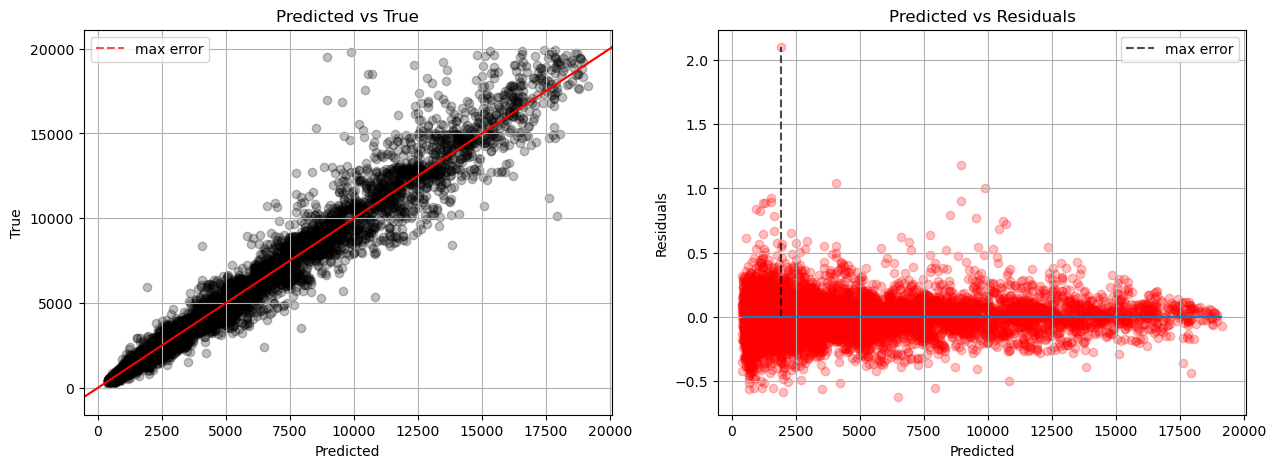

In [18]:
plot_2_error(y_test, knn_pipline.predict(X_test))

In [17]:
knn_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', KNeighborsRegressor(n_neighbors=4, p=1))])

knn_pipline.fit(X_train, y_train)
y_pred = knn_pipline.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

0.08671143088660865


In [18]:
knn_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', KNeighborsRegressor(n_neighbors=7, p=1))])

knn_pipline.fit(X_train, y_train)
y_pred = knn_pipline.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

0.08631955615401286


Модель с 5 соседями хорошо себя показала на тестовом наборе

Попробуем модели линейных регрессий и байесовскую 

In [19]:
linreg_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', LinearRegression())])

param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'regressor': [LinearRegression()]  
     }]


result = GridSearchCV(linreg_pipline, param_grid, cv=10, scoring = 'neg_mean_absolute_percentage_error') 
result.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

Наилучшие параметры:
{'preprocessor__data_transformer__numerical__scaler': StandardScaler(), 'regressor': LinearRegression()}

-0.36048936479810806


,1,2,0
mean_fit_time,0.284414,0.282093,0.285949
std_fit_time,0.012545,0.011181,0.012855
mean_score_time,0.017405,0.018019,0.018804
std_score_time,0.000917,0.002319,0.002601
param_preprocessor__data_transformer__numerical__scaler,StandardScaler(),RobustScaler(),MinMaxScaler()
param_regressor,LinearRegression(),LinearRegression(),LinearRegression()
params,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...
split0_test_score,-0.3609,-0.361005,-0.360739
split1_test_score,-0.361797,-0.361641,-0.36213
split2_test_score,-0.361994,-0.362042,-0.362314


In [20]:
knn_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', LinearRegression())])

knn_pipline.fit(X_train, y_train)
y_pred = knn_pipline.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

0.3630328370862276


В целом рез-т похуже чем в модели ближайших соседей

In [21]:
ridge_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', Ridge())])

param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'regressor': [Ridge()],
         'regressor__alpha': [1, 10, 30, 50, 100]
     }]


result = GridSearchCV(ridge_pipline, param_grid, cv=10, scoring = 'neg_mean_absolute_percentage_error') 
result.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

Наилучшие параметры:
{'preprocessor__data_transformer__numerical__scaler': RobustScaler(), 'regressor': Ridge(), 'regressor__alpha': 100}

-0.3465746004981464


,14,9,13,8,12,7,11,6,10,5,0,1,2,3,4
mean_fit_time,0.306892,0.286644,0.289685,0.2805,0.289219,0.2802,0.304029,0.279734,0.289776,0.283315,0.283665,0.281107,0.280471,0.276948,0.278901
std_fit_time,0.032086,0.014294,0.010261,0.009541,0.011625,0.013279,0.017552,0.011543,0.006123,0.016468,0.011215,0.015108,0.01064,0.011864,0.009873
mean_score_time,0.019212,0.018729,0.017604,0.017604,0.017803,0.017404,0.018603,0.018004,0.018004,0.017804,0.017804,0.017404,0.017842,0.017104,0.017805
std_score_time,0.002674,0.001373,0.00102,0.001281,0.000873,0.001114,0.001429,0.00179,0.001732,0.0014,0.001327,0.001019,0.001307,0.001446,0.001328
param_preprocessor__data_transformer__numerical__scaler,RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_regressor,Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge(),Ridge()
param_regressor__alpha,100,100,50,50,30,30,10,10,1,1,1,10,30,50,100
params,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...
split0_test_score,-0.347474,-0.348154,-0.35372,-0.353947,-0.356492,-0.35658,-0.359376,-0.359399,-0.360732,-0.360735,-0.362374,-0.378768,-0.416185,-0.436645,-0.452466
split1_test_score,-0.346732,-0.347325,-0.353727,-0.3539,-0.356844,-0.356914,-0.360112,-0.360127,-0.361627,-0.361628,-0.362653,-0.378462,-0.415472,-0.435478,-0.450441


In [22]:
lasso_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', Lasso())])

param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'regressor': [Lasso(max_iter=5000)],
         'regressor__alpha': [0.01, 0.05, 0.1, 0.5, 1]
     }]


result = GridSearchCV(lasso_pipline, param_grid, cv=10, scoring = 'neg_mean_absolute_percentage_error') 
result.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

C:\Users\mails\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.125e+07, tolerance: 4.740e+07
  model = cd_fast.enet_coordinate_descent(


Наилучшие параметры:
{'preprocessor__data_transformer__numerical__scaler': StandardScaler(), 'regressor': Lasso(max_iter=5000), 'regressor__alpha': 1}

-0.3554196900029803


,9,14,8,13,7,12,3,11,6,2,1,10,5,0,4
mean_fit_time,0.947842,0.848959,1.16433,1.066058,1.777817,1.722574,0.748725,2.044095,2.430176,0.83222,1.231924,3.914448,4.096434,1.997036,0.602224
std_fit_time,0.124143,0.060394,0.111279,0.102017,0.156978,0.123788,0.037949,0.141028,0.42285,0.051491,0.127947,1.199745,1.3065,0.242113,0.057692
mean_score_time,0.021204,0.01907,0.020405,0.018904,0.019104,0.019404,0.019803,0.019917,0.024405,0.018504,0.020303,0.020028,0.019404,0.021012,0.019401
std_score_time,0.002442,0.000953,0.002059,0.002468,0.001921,0.001562,0.001326,0.001826,0.004631,0.001432,0.003037,0.002292,0.0012,0.002491,0.001356
param_preprocessor__data_transformer__numerical__scaler,StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler()
param_regressor,Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000),Lasso(max_iter=5000)
param_regressor__alpha,1,1,0.5,0.5,0.1,0.1,0.5,0.05,0.05,0.1,0.05,0.01,0.01,0.01,1
params,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...
split0_test_score,-0.355749,-0.355772,-0.358276,-0.358291,-0.36032,-0.360317,-0.360863,-0.360592,-0.360594,-0.360976,-0.360912,-0.360824,-0.360825,-0.360872,-0.361876
split1_test_score,-0.356326,-0.35636,-0.359039,-0.359055,-0.361242,-0.361245,-0.360884,-0.361521,-0.361519,-0.361582,-0.361679,-0.361742,-0.361742,-0.361782,-0.361149


In [23]:
SGDR_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', SGDRegressor())])

param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'regressor': [SGDRegressor()]
     }]


result = GridSearchCV(SGDR_pipline, param_grid, cv=10, scoring = 'neg_mean_absolute_percentage_error') 
result.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

Наилучшие параметры:
{'preprocessor__data_transformer__numerical__scaler': RobustScaler(), 'regressor': SGDRegressor()}

-0.3604565543424621


,2,1,0
mean_fit_time,0.437114,0.454054,3.738723
std_fit_time,0.02803,0.041842,0.450974
mean_score_time,0.015079,0.016405,0.015105
std_score_time,0.000668,0.002538,0.000699
param_preprocessor__data_transformer__numerical__scaler,RobustScaler(),StandardScaler(),MinMaxScaler()
param_regressor,SGDRegressor(),SGDRegressor(),SGDRegressor()
params,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...
split0_test_score,-0.367419,-0.36026,-0.373361
split1_test_score,-0.360338,-0.362847,-0.369112
split2_test_score,-0.361376,-0.3589,-0.376536


In [24]:
knn_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('knn', SGDRegressor())])

knn_pipline.fit(X_train, y_train)
y_pred = knn_pipline.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

0.3735991456172648


In [25]:
bayesian_pipline = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('regressor', BayesianRidge())])

param_grid =[
    {'preprocessor__data_transformer__numerical__scaler': scaling, 
     'regressor': [BayesianRidge()]
     }]


result = GridSearchCV(bayesian_pipline, param_grid, cv=10, scoring = 'neg_mean_absolute_percentage_error') 
result.fit(X_train, y_train)

print("Наилучшие параметры:\n{}\n".format(result.best_params_))
print(result.best_score_)
grid_result = pd.DataFrame(result.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

Наилучшие параметры:
{'preprocessor__data_transformer__numerical__scaler': RobustScaler(), 'regressor': BayesianRidge()}

-0.3604212956465456


,2,1,0
mean_fit_time,0.364681,0.672649,0.447713
std_fit_time,0.030119,0.265393,0.116129
mean_score_time,0.019104,0.033909,0.024307
std_score_time,0.002211,0.010115,0.007324
param_preprocessor__data_transformer__numerical__scaler,RobustScaler(),StandardScaler(),MinMaxScaler()
param_regressor,BayesianRidge(),BayesianRidge(),BayesianRidge()
params,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...,{'preprocessor__data_transformer__numerical__s...
split0_test_score,-0.360787,-0.3608,-0.360929
split1_test_score,-0.361689,-0.361702,-0.361817
split2_test_score,-0.361884,-0.361897,-0.362014


В итоге модель ближайших соседей оказалась лучше всех остальных представленных.